In [143]:
!pip install --user pandoc

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [17]:
from sklearn.model_selection import train_test_split

from sklearn.grid_search import GridSearchCV
from sklearn.grid_search import RandomizedSearchCV
from scipy.stats import uniform
from scipy.stats import norm

from imblearn.over_sampling import SMOTE

import sqlite3

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import gensim

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from sklearn.preprocessing import StandardScaler

In [32]:
con = sqlite3.connect('final.sqlite') # this is cleaned dataset
final = pd.read_sql_query("""
SELECT Score, Text_not_included
FROM reviews
""", con)[:15000]

for i, seq in enumerate(final['Text_not_included']):
  final['Text_not_included'][i]=final['Text_not_included'][i].decode('UTF-8')
X_train, X_test, y_train , y_test = train_test_split(final['Text_not_included'], final['Score'], test_size=0.2, shuffle=False)

In [33]:
tf_idf_vect=TfidfVectorizer(ngram_range=(1,2), min_df=10, dtype=float)
tf_idf_vect.fit(X_train)
tf_idf_train=tf_idf_vect.transform(X_train)
tf_idf_test=tf_idf_vect.transform(X_test)

/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


In [34]:
sentences=[]
for review in X_train:
  sentence=[]
  for word in review.split():
    sentence.append(word)
  sentences.append(sentence)

w2vec_model=gensim.models.word2vec.Word2Vec(sentences, min_count=10)

avg_w2vec_train=np.zeros(shape=(len(X_train), 100), dtype=float)

for i, sentence in enumerate(sentences):
  for word in sentence:
    try:
      avg_w2vec_train[i]+=w2vec_model.wv[word]
    
    except KeyError:
      pass
  
  avg_w2vec_train[i]/=len(sentence)

sentences=[]
for review in X_test:
  sentence=[]
  for word in review.split():
    sentence.append(word)
  sentences.append(sentence)

avg_w2vec_test=np.zeros(shape=(len(X_test), 100), dtype=float)

for i, sentence in enumerate(sentences):
  for word in sentence:
    try:
      avg_w2vec_test[i]+=w2vec_model.wv[word]
    
    except KeyError:
      pass
  
  avg_w2vec_test[i]/=len(sentence)

In [35]:
sentences=[]
for review in X_train:
  sentence=[]
  for word in review.split():
    sentence.append(word)
  sentences.append(sentence)
  
tf_idf_w2vec_train=np.zeros((len(X_train), 100), dtype=float)
feat=tf_idf_vect.get_feature_names()
for i, sentence in enumerate(sentences):
  tf_idf_sum=0
  for word in sentence:
    try:
      tf_idf_w2vec_train[i]+=w2vec_model.wv[word]*tf_idf_train[i, feat.index(word)]
      tf_idf_sum+=tf_idf_train[i, feat.index(word)]  
    except KeyError:
      pass
    except ValueError:
      pass
  tf_idf_w2vec_train[i]/=tf_idf_sum
  
sentences=[]
for review in X_test:
  sentence=[]
  for word in review.split():
    sentence.append(word)
  sentences.append(sentence)
  
tf_idf_w2vec_test=np.zeros((len(X_test), 100), dtype=float)

for i, sentence in enumerate(sentences):
  tf_idf_sum=0
  for word in sentence:
    try:
      tf_idf_w2vec_test[i]+=w2vec_model.wv[word]*tf_idf_test[i, feat.index(word)]
      tf_idf_sum+=tf_idf_test[i, feat.index(word)]  
    except KeyError:
      pass
    except ValueError:
      pass
  tf_idf_w2vec_test[i]/=tf_idf_sum

In [106]:
# Upsampling minority class
over_sampler = SMOTE(ratio='minority')

avg_w2vec_train_resampled, y_train_resampled = over_sampler.fit_sample(avg_w2vec_train, y_train)
tf_idf_w2vec_train_resampled, y_train_resampled = over_sampler.fit_sample(tf_idf_w2vec_train, y_train)

In [12]:
from sklearn.tree import DecisionTreeClassifier

## Classification using avg_word2Vec

In [128]:
param_grid={'max_depth' : [i for i in range(1,20,1)]}

gscv=GridSearchCV(DecisionTreeClassifier(), param_grid, scoring='accuracy', cv=5)

In [129]:
print(gscv.fit(avg_w2vec_train_resampled, y_train_resampled))

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)


In [130]:
predictions = gscv.best_estimator_.predict(avg_w2vec_test)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions).T)
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

print("TPR = {}\n TNR = {}\n FPR = {}\n FNR = {}".format(tp/(fn+tp), tn/(tn+fp), fp/(tn+fp), fn/(fn+tp)))

             precision    recall  f1-score   support

   negative       0.34      0.61      0.44       505
   positive       0.91      0.76      0.83      2495

avg / total       0.81      0.74      0.76      3000

[[ 308  593]
 [ 197 1902]]
TPR = 0.7623246492985972
 TNR = 0.6099009900990099
 FPR = 0.3900990099009901
 FNR = 0.2376753507014028


In [131]:
gscv.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=16,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## Classification using tfidf weighted word2vec

In [132]:
print(gscv.fit(tf_idf_w2vec_train_resampled, y_train_resampled))

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)


In [133]:
predictions = gscv.best_estimator_.predict(tf_idf_w2vec_test)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions).T)
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

print("TPR = {}\n TNR = {}\n FPR = {}\n FNR = {}".format(tp/(fn+tp), tn/(tn+fp), fp/(tn+fp), fn/(fn+tp)))

             precision    recall  f1-score   support

   negative       0.32      0.57      0.41       505
   positive       0.90      0.76      0.82      2495

avg / total       0.80      0.73      0.75      3000

[[ 289  606]
 [ 216 1889]]
TPR = 0.7571142284569138
 TNR = 0.5722772277227722
 FPR = 0.4277227722772277
 FNR = 0.24288577154308616


In [134]:
gscv.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=18,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## Effect of changing depth

In [79]:
import matplotlib.pyplot as plt
%matplotlib inline

In [135]:
depths=range(1,30,1)

accuracy=np.zeros((2,30))

for d in depths:
    clf_w2v=DecisionTreeClassifier(max_depth=d)
    clf_w2v.fit(avg_w2vec_train_resampled, y_train_resampled)
    
    clf_tfidfw2v=DecisionTreeClassifier(max_depth=d)
    clf_tfidfw2v.fit(tf_idf_w2vec_train_resampled, y_train_resampled)
    
    predictions_w2vec=clf_w2v.predict(avg_w2vec_test)
    predictions_tfidfword2vec=clf_tfidfw2v.predict(tf_idf_w2vec_test)
    
    acc_w2v=accuracy_score(y_test, predictions_w2vec)
    acc_tfidfw2v=accuracy_score(y_test, predictions_tfidfword2vec)
    
    accuracy[0,d-1]=acc_w2v
    accuracy[1,d-1]=acc_tfidfw2v

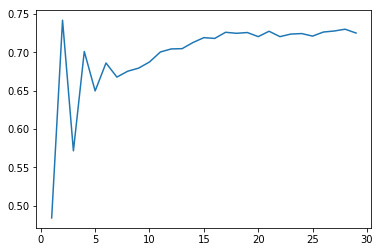

In [140]:
plt.plot(depths, accuracy[1][:29])

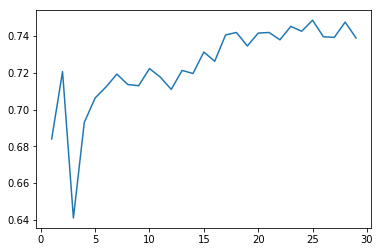

In [141]:
plt.plot(depths, accuracy[0][:29])

## Conclusion

Ignoring a few irregularities, accuracy in general increases with depth upto some value of d and then starts decreasing<br><br>

The ideal values of depth for both vector representations have been found<br>
tfidf weighted : 18<br>
avg word2vec : 16<br><br>

Decisions trees provide a significant boost in training speed as opposed to SVMs and also offer better TNR